In [1]:
import os
import re
import json
import socket
import subprocess
import pandas as pd
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import utils as pu
from pyspark.sql import functions as F
from pyspark.sql import types as pt

## Assignment #1 

This task rely on to 

In [2]:
print('user:', os.environ['JUPYTERHUB_SERVICE_PREFIX'])

def uiWebUrl(self):
    from urllib.parse import urlparse
    web_url = self._jsc.sc().uiWebUrl().get()
    port = urlparse(web_url).port
    return '{}proxy/{}/jobs/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)

SparkContext.uiWebUrl = property(uiWebUrl)

conf = SparkConf().set('spark.master', 'local[*]').set('spark.driver.memory', '4g').set("spark.executor.instances", "4")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark

user: /user/st039823/


## Songs 

The songs. Note that data is in unicode.

- song_id
- song_length: in ms
- genre_ids: genre category. Some songs have multiple genres and they are separated by |
- artist_name
- composer
- lyricist
- language


In [3]:
songs = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/__DATA/big_data_2022/labs/kkbox-music-recommendation-challenge/songs.csv")

songs.limit(100).toPandas().head(10)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,None,None,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
5,kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=,235520,864|857|850|843,貴族精選,Joe Hisaishi,Hayao Miyazaki,17.0
6,N9vbanw7BSMoUgdfJlgX1aZPE1XZg8OS1wf88AQEcMc=,226220,458,伍佰 & China Blue,Jonathan Lee,None,3.0
7,GsCpr618xfveHYJdo+E5SybrpR906tsjLMeKyrCNw8s=,276793,465,光良 (Michael Wong),光良,彭資閔,3.0
8,oTi7oINPX+rxoGp+3O6llSltQTl80jDqHoULfRoLcG4=,228623,465,林俊傑 (JJ Lin),JJ Lin,Wu Qing Feng,3.0
9,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,232629,352|1995,Kodaline,Stephen Garrigan| Mark Prendergast| Vincent Ma...,Stephen Garrigan| Mark Prendergast| Vincent Ma...,52.0


## "Train" data

Some data of users listen history 

- msno: user id
- song_id: song id
- source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
- source_screen_name: name of the layout a user sees.
- source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
- target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .


In [4]:
listen_history = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/__DATA/big_data_2022/labs/kkbox-music-recommendation-challenge/train.csv")

listen_history.show()

+--------------------+--------------------+-----------------+-------------------+-------------------+------+
|                msno|             song_id|source_system_tab| source_screen_name|        source_type|target|
+--------------------+--------------------+-----------------+-------------------+-------------------+------+
|FGtllVqz18RPiwJj/...|BBzumQNXUHKdEBOB7...|          explore|            Explore|    online-playlist|     1|
|Xumu+NIjS6QYVxDS4...|bhp/MpSNoqoxOIB+/...|       my library|Local playlist more|     local-playlist|     1|
|Xumu+NIjS6QYVxDS4...|JNWfrrC7zNN7BdMps...|       my library|Local playlist more|     local-playlist|     1|
|Xumu+NIjS6QYVxDS4...|2A87tzfnJTSWqD7gI...|       my library|Local playlist more|     local-playlist|     1|
|FGtllVqz18RPiwJj/...|3qm6XTZ6MOCU11x8F...|          explore|            Explore|    online-playlist|     1|
|FGtllVqz18RPiwJj/...|3Hg5kugV1S0wzEVLA...|          explore|            Explore|    online-playlist|     1|
|Xumu+NIjS6QYVxDS4.

## Assignment:

PREFER DATA FRAME API(!)

Vision of result:
- self-sufficient jupyter notebook
- not only the code but n
- published on github 
- link to your github attached here https://docs.google.com/spreadsheets/d/1F8ScpCCiBaxiyZqDd09jn6t25pykiK8oauJbRuuA8Q4/edit?usp=sharing


Task 1: 
- Find out top-20 of most popular artist's in terms of: raw listens, unique users listens;

Task 2: 
- find out top-3 languages by num of raw listens
- build histogram of songs length by language / genre. What is the longest genre? What is more valuable in terms of length: language or genre? 

Deadlines:
- soft 17.05
- hard 24.05

songs = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/malyutin_temp/kkbox-music-recommendation-challenge/song_extra_info.csv")

songs.limit(100).toPandas().head(10)

## Task_1 (Top 20)

In [5]:
# use the approach from lecture 4
joined = listen_history.join(songs, ["song_id"], 'inner')

joined.groupBy("artist_name")\
.agg(F.count(F.col("msno")).alias("raw listens"))\
.orderBy(F.col("raw listens").desc())\
.limit(100).toPandas().head(20)

,artist_name,raw listens
0,Various Artists,303617
1,周杰倫 (Jay Chou),186776
2,五月天 (Mayday),182088
3,林俊傑 (JJ Lin),115325
4,田馥甄 (Hebe),104946
5,aMEI (張惠妹),82799
6,陳奕迅 (Eason Chan),76035
7,玖壹壹,70445
8,G.E.M.鄧紫棋,67297
9,BIGBANG,61927


In [6]:
joined.groupBy("artist_name")\
.agg(F.countDistinct(F.col("msno")).alias("unique users listens"))\
.orderBy(F.col("unique users listens").desc())\
.limit(100).toPandas().head(20)

,artist_name,unique users listens
0,Various Artists,22256
1,田馥甄 (Hebe),18771
2,周杰倫 (Jay Chou),18727
3,五月天 (Mayday),18183
4,林俊傑 (JJ Lin),17160
5,陳奕迅 (Eason Chan),16290
6,G.E.M.鄧紫棋,16064
7,Eric 周興哲,15672
8,謝和弦 (R-chord),15313
9,aMEI (張惠妹),15169


## Task_2

In [7]:
# the same trick (top3)
joined.groupBy("language")\
.agg(F.count(F.col("msno")).alias("raw listens"))\
.orderBy(F.col("raw listens").desc())\
.limit(100).toPandas().head(3)

,language,raw listens
0,3.0,4044643
1,52.0,1864788
2,31.0,656623


In [8]:
# build histogram of songs length by language / genre. 
# What is the longest genre? 
# What is more valuable in terms of length: language or genre?

In [9]:
# let's take mean as a standard for comparison
sl_lang = songs.groupBy("language")\
.agg(F.mean(F.col("song_length")).alias("song_length_mean"))\
.orderBy(F.col("song_length_mean").desc())\
.limit(100).toPandas().head(10)

In [10]:
sl_lang
# there is no real need for more than top 10

,language,song_length_mean
0,10,301803.666667
1,17,293179.785714
2,59,285330.333333
3,-1.0,275935.120002
4,-1,266340.979730
5,24,252539.500000
6,17.0,250420.907067
7,45,247327.000000
8,3.0,244118.316393
9,10.0,243567.000452


<BarContainer object of 10 artists>

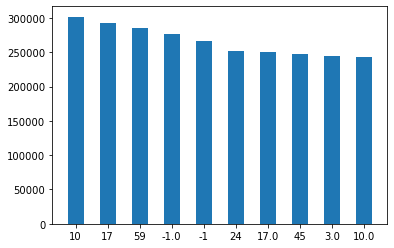

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.bar(sl_lang['language'], sl_lang['song_length_mean'], width = 0.5)

In [12]:
sl_genre = songs.groupBy("genre_ids")\
.agg(F.mean(F.col("song_length")).alias("song_length_mean"))\
.orderBy(F.col("song_length_mean").desc())\
.limit(100).toPandas().head(10)

In [13]:
sl_genre

,genre_ids,song_length_mean
0,1969|786|2100,2.832230e+06
1,1969|465|2100,1.347814e+06
2,1096|958,1.284257e+06
3,873|545,1.168195e+06
4,1152|873|947,9.434058e+05
5,474,9.120666e+05
6,495,8.878777e+05
7,1152|873,8.150285e+05
8,516|829,7.240090e+05
9,1152|509,7.169040e+05


In [14]:
# there are quite a lot of "combined genres"
# not sure if we are interested in solo genres, so let's assume that these are also unique genres

<BarContainer object of 10 artists>

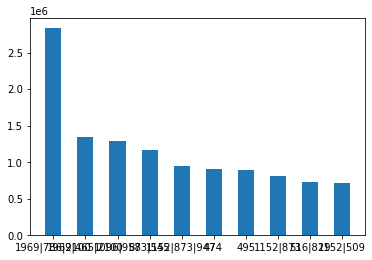

In [15]:
plt.bar(sl_genre['genre_ids'], sl_genre['song_length_mean'], width = 0.5)

## Answers: 
What is the longest genre? 
	1969|786|2100	
What is more valuable in terms of length: language or genre?
I prefer language since genre is a bit confusing (it may be the opposite if we have specifications)